----
# <b> Mini Project - ML for Time Series </b>
# Matteo MARENGO | matteo.marengo@ens-paris-saclay.fr
# Hugo ROBERT | hugo.robert@ens-paris-saclay.fr
----

# <b>1 : Setup and Data</b>

## <b> 1.1 : Installation </b>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cd '/content/drive/MyDrive/MVA-2023-2024/TIME_SERIES/TSFEL-LIBRARY/DTW'
!pwd

/bin/bash: line 1: cd: /content/drive/MyDrive/MVA-2023-2024/TIME_SERIES/TSFEL-LIBRARY/DTW: No such file or directory
/content


In [3]:
!pip install dtw-python
!pip install loadmydata
!pip install tsfel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.5/645.5 kB 7.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for loadmydata: filename=loadmydata-0.0.11-py3-none-any.whl size=18022 sha256=e0c15519b95ba4815840756a97194ad61f1a4ab3fe15581484e5c214f5f222f2
  Stored in directory: /root/.cache/pip/wheels/43/16/85/7c6a4152d2b99f1e83db216f6a0e8116700f0f03cc555f2c7c
Successfully built loadmydata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.4 MB/s eta 0:00:00


## <b> 1.2 : Import the library </b>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tsfel
from sklearn.decomposition import PCA
from dtw import dtw
import pandas as pd
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



----
## <b> 1.3 : Utility functions</b>

In [5]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax

----
----
# <b> 2 : Dynamic time warping (DTW)</b>

## <b> 2.1 : Data</b>

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length).

Signals are sampled at <b>100 Hz</b>.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

**The task** is to classify footsteps in healthy/non-healthy.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

----
## <b> 2.2 : Train and Test Datasets </b>

In [18]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train_raw = list()  # list of footstep signals
y_train_raw = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_train_raw.append(signal[start:end])
        y_train_raw.append(label)


X_test_raw = list()  # list of footstep signals
y_test_raw = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_test_raw.append(signal[start:end])
        y_test_raw.append(label)

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X = np.concatenate((X_train_raw, X_test_raw), axis=0)
y = np.concatenate((y_train_raw, y_test_raw), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = X_train.tolist(), X_test.tolist(), y_train.tolist(), y_test.tolist()

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [43]:
# data normalization
for index in range(len(X_train)):
    x = np.array(X_train[index])
    mean = sum(x) / len(x)
    standard_deviation = np.sqrt( sum( (x - mean)**2 ) / len(x))
    X_train[index] = (x - mean) / standard_deviation
for index in range(len(X_test)):
    x = np.array(X_test[index])
    mean = sum(x) / len(x)
    standard_deviation = np.sqrt( sum( (x - mean)**2 ) / len(x))
    X_test[index] = (x - mean) / standard_deviation

----
## <b> 2.3 : DTW KNN

In [44]:
k_values = [1, 3, 5, 7, 9]
best_score, best_k = 0,0

X_train_matrix = np.zeros((len(X_train),len(X_train)))
for i in range(len(X_train)):
    for j in range(len(X_train)):
        X_train_matrix[i,j] = dtw(X_train[i], X_train[j]).distance

X_test_matrix = np.zeros((len(X_test),len(X_train)))
for i in range(len(X_test)):
    for j in range(len(X_train)):
        X_test_matrix[i,j] = dtw(X_test[i], X_train[j]).distance

print("score for KNeighborsClassifier with")

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric="precomputed")
    knn.fit(X_train_matrix, y_train)
    score = knn.score(X_test_matrix, y_test).mean()
    print(f"\t{k} neighbors: {score}")
    if score > best_score:
        best_score=score
        best_k = k
        best_knn = knn

print(f"Optimal number of neighbor(s): {best_k}")
print(f"Associated F-score: {best_score}")
accuracy_dtw = best_score

score for KNeighborsClassifier with
	1 neighbors: 0.8076923076923077
	3 neighbors: 0.7884615384615384
	5 neighbors: 0.8269230769230769
	7 neighbors: 0.7884615384615384
	9 neighbors: 0.7884615384615384
Optimal number of neighbor(s): 5
Associated F-score: 0.8269230769230769


----
## <b> 2.4 : Plot Healthy vs Non Healthy Patient </b>

In [ ]:
y_pred = best_knn.predict(X_test_matrix)

bad_healthy_pred = next((i for i, (pred, true) in enumerate(zip(y_pred, y_test)) if pred != true and true == 0), None) # first bad prediction for an healthy patient
bad_non_healthy_pred = next((i for i, (pred, true) in enumerate(zip(y_pred, y_test)) if pred != true and true == 1), None) # first bad prediction for a non-healthy patient


plt.plot(X_test[bad_healthy_pred])
plt.savefig('figuresQ11_badly_classified_healthy_patient.png')
plt.clf()
plt.plot(X_test[bad_non_healthy_pred])
plt.savefig('figuresQ11_badly_classified_non_healthy_patient.png')
plt.clf()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(X_test[bad_healthy_pred])
ax1.set_title('badly_classified_healthy_patient.png')
ax2.plot(X_test[bad_non_healthy_pred])
ax2.set_title('badly classified non-healthy patient')
plt.show()

----
----
# <b> 3 : TSFEL </b>

## <b> 3.1 : Feature Extraction </b>

In [46]:
cfg_file = tsfel.get_features_by_domain()

X_train_generic = tsfel.time_series_features_extractor(cfg_file, X_train)
X_test_generic = tsfel.time_series_features_extractor(cfg_file, X_test)

*** Feature extraction started ***


<ipython-input-46-20b09bffb934>:3: UserWarning: Using default sampling frequency set in configuration file.
  X_train_generic = tsfel.time_series_features_extractor(cfg_file, X_train)



*** Feature extraction finished ***
*** Feature extraction started ***


<ipython-input-46-20b09bffb934>:4: UserWarning: Using default sampling frequency set in configuration file.
  X_test_generic = tsfel.time_series_features_extractor(cfg_file, X_test)



*** Feature extraction finished ***


In [47]:
new_features = [new_feature for new_feature in X_test_generic.columns if new_feature not in X_train_generic.columns]
X_test_generic.drop(new_features, axis=1, inplace=True)

In [54]:
# we will keep only columns in common between train and test dataset (this is because the time series are of different lengths)
common_columns = X_train_generic.columns.intersection(X_test_generic.columns)

X_train_generic = X_train_generic[common_columns]
X_test_generic = X_test_generic[common_columns]

In [55]:
# Highly correlated features are removed
corr_features = tsfel.correlated_features(X_train_generic)
X_train_generic.drop(corr_features, axis=1, inplace=True)
X_test_generic.drop(corr_features, axis=1, inplace=True)

# Remove low variance features
selector = VarianceThreshold()
nX_train_generic = selector.fit_transform(X_train_generic)
nX_test_generic = selector.transform(X_test_generic)

# Normalising Features
scaler = preprocessing.StandardScaler()
nX_train_generic = scaler.fit_transform(nX_train_generic)
nX_test_generic = scaler.transform(nX_test_generic)

# drop features with Nan
nan_features = np.argwhere(np.isnan(nX_test_generic))
nan_features = np.unique(nan_features[:,1])

# remove features with NaN values
nX_train_generic = np.delete(nX_train_generic, nan_features, axis=1)
nX_test_generic = np.delete(nX_test_generic, nan_features, axis=1)

nan_features = np.argwhere(np.isnan(nX_train_generic))
nan_features = np.unique(nan_features[:,1])

# remove features with NaN values
nX_train_generic = np.delete(nX_train_generic, nan_features, axis=1)
nX_test_generic = np.delete(nX_test_generic, nan_features, axis=1)

<ipython-input-55-658d24295f10>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_generic.drop(corr_features, axis=1, inplace=True)


----
## <b> 3.2 : PCA+kNN </b>

Explained Variance Ratio: [0.29881517 0.21547914 0.08619176 0.06324873 0.04968022]


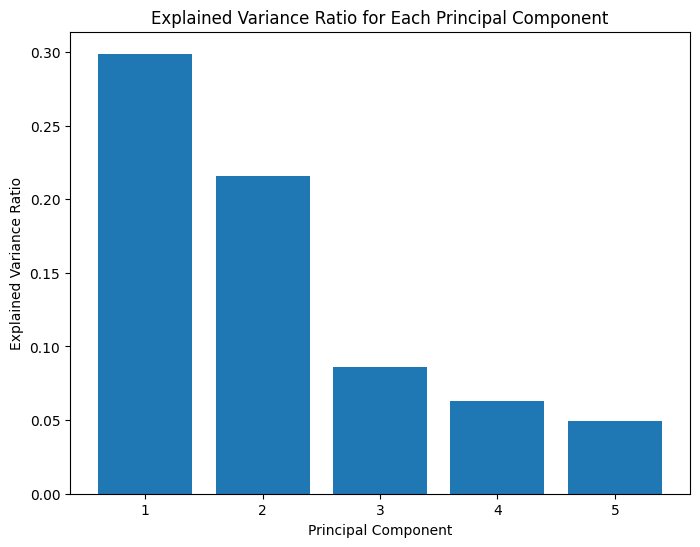

In [120]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Choose the number of components (principal components) you want to retain
n_components = 5  # You can adjust this value based on your visualization needs

pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(nX_train_generic)
X_test_pca = pca.transform(nX_test_generic)


explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained Variance Ratio: {explained_variance_ratio}")

# Plot the explained variance for each component
plt.figure(figsize=(8, 6))
plt.bar(range(1, n_components + 1), explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for Each Principal Component')
plt.show()


Au vu de la répartition des variances, nous allons garder les 2 premieres composantes

In [121]:
# Create a kNN classifier (you can choose an appropriate value for k)
k = 5
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Train the kNN classifier using the PCA-transformed training data
knn_classifier.fit(X_train_pca, y_train)  # Assuming you have target labels (y_train)

# Make predictions on the PCA-transformed test data
y_pred = knn_classifier.predict(X_test_pca)

# Evaluate the classifier's performance
accuracy_tsfel = accuracy_score(y_test, y_pred)
print(f"Accuracy of kNN classifier: {accuracy_tsfel}")

Accuracy of kNN classifier: 0.7115384615384616


----
----
# <b> 4 : TSFRESH </b>

In [58]:
!pip install tsfresh
!pip install stumpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.3/95.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 8.6 MB/s eta 0:00:00


----
## <b> 4.1 : Dataframe Creation </b>

In [81]:
import tsfresh
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import MinimalFCParameters,EfficientFCParameters,ComprehensiveFCParameters
from tsfresh import select_features,extract_features,extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute

# Initialize an empty list to store temporary DataFrames
temp_dfs = []
fs = 100

# Iterate over the series in x_train_sig
for i, series in enumerate(X_train):
    # Create a temporary DataFrame for each series
    temp = pd.DataFrame({
        'value': series,
        'time': [t * (1 / fs) for t in range(len(series))],  # Corrected line
        'id': i
    })
    # Append the temporary DataFrame to the list
    temp_dfs.append(temp)

# Concatenate all the temporary DataFrames into one DataFrame
df_train = pd.concat(temp_dfs, ignore_index=True)

#######
#######

# Initialize an empty list to store temporary DataFrames
temp_dfs = []

# Iterate over the series in x_train_sig
for i, series in enumerate(X_test):
    # Create a temporary DataFrame for each series
    temp = pd.DataFrame({
        'value': series,
        'time': [t * (1 / fs) for t in range(len(series))],  # Corrected line
        'id': i
    })
    # Append the temporary DataFrame to the list
    temp_dfs.append(temp)

# Concatenate all the temporary DataFrames into one DataFrame
df_test = pd.concat(temp_dfs, ignore_index=True)

In [82]:
print(df_train.shape)
print(df_train.head)
print(df_test.shape)
print(df_test.head)

(15615, 3)
<bound method NDFrame.head of           value  time   id
0      0.020636  0.00    0
1      0.061881  0.01    0
2      0.138682  0.02    0
3      0.216052  0.03    0
4      0.290862  0.04    0
...         ...   ...  ...
15610 -0.079436  0.61  203
15611  0.260427  0.62  203
15612  0.309128  0.63  203
15613  0.140731  0.64  203
15614 -0.050223  0.65  203

[15615 rows x 3 columns]>
(4003, 3)
<bound method NDFrame.head of          value  time  id
0     0.755145  0.00   0
1     0.778895  0.01   0
2     0.747229  0.02   0
3     0.736344  0.03   0
4     0.727438  0.04   0
...        ...   ...  ..
3998  1.717057  0.69  51
3999 -0.403885  0.70  51
4000  0.433153  0.71  51
4001  0.196990  0.72  51
4002  0.061554  0.73  51

[4003 rows x 3 columns]>


----
## <b> 4.2 : Mini</b>

In [83]:
from tsfresh.feature_extraction import MinimalFCParameters,EfficientFCParameters
from tsfresh import select_features,extract_features,extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute
# Use MinimalFCParameters
extraction_settings = MinimalFCParameters()

# Feature extraction with error handling and progress information
try:
    X_train_Tsfresh_Mini = extract_features(df_train, column_id='id', column_sort='time', column_value='value',
                                    default_fc_parameters=extraction_settings,
                                    impute_function=impute,
                                    )

    print("Feature set type:", type(X_train_Tsfresh_Mini))
    print("Number of features extracted:", len(X_train_Tsfresh_Mini.columns))
    print("Shape of the feature set:", X_train_Tsfresh_Mini.shape)

    # Optionally, save the feature set to a file
    # fset_tsfresh.to_csv('feature_set.csv')

except Exception as e:
    print(f"An error occurred during feature extraction: {e}")

# Feature extraction with error handling and progress information
try:
    X_test_Tsfresh_Mini = extract_features(df_test, column_id='id', column_sort='time', column_value='value',
                                    default_fc_parameters=extraction_settings,
                                    impute_function=impute,
                                    )

    print("Feature set type:", type(X_test_Tsfresh_Mini))
    print("Number of features extracted:", len(X_test_Tsfresh_Mini.columns))
    print("Shape of the feature set:", X_test_Tsfresh_Mini.shape)

    # Optionally, save the feature set to a file
    # fset_tsfresh.to_csv('feature_set.csv')

except Exception as e:
    print(f"An error occurred during feature extraction: {e}")



Feature Extraction: 100%|██████████| 204/204 [00:00<00:00, 1037.27it/s]


Feature set type: <class 'pandas.core.frame.DataFrame'>
Number of features extracted: 10
Shape of the feature set: (204, 10)


Feature Extraction: 100%|██████████| 52/52 [00:00<00:00, 1120.86it/s]

Feature set type: <class 'pandas.core.frame.DataFrame'>
Number of features extracted: 10
Shape of the feature set: (52, 10)


----
## <b> 4.3 : Efficient </b>

In [84]:
from tsfresh.feature_extraction import MinimalFCParameters,EfficientFCParameters
from tsfresh import select_features,extract_features,extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute
# Use MinimalFCParameters
extraction_settings = EfficientFCParameters()

# Feature extraction with error handling and progress information
try:
    X_train_Tsfresh_Effi = extract_features(df_train, column_id='id', column_sort='time', column_value='value',
                                    default_fc_parameters=extraction_settings,
                                    impute_function=impute,
                                    )

    print("Feature set type:", type(X_train_Tsfresh_Effi))
    print("Number of features extracted:", len(X_train_Tsfresh_Effi.columns))
    print("Shape of the feature set:", X_train_Tsfresh_Effi.shape)

    # Optionally, save the feature set to a file
    # fset_tsfresh.to_csv('feature_set.csv')

except Exception as e:
    print(f"An error occurred during feature extraction: {e}")

# Feature extraction with error handling and progress information
try:
    X_test_Tsfresh_Effi = extract_features(df_test, column_id='id', column_sort='time', column_value='value',
                                    default_fc_parameters=extraction_settings,
                                    impute_function=impute,
                                    )

    print("Feature set type:", type(X_test_Tsfresh_Effi))
    print("Number of features extracted:", len(X_test_Tsfresh_Effi.columns))
    print("Shape of the feature set:", X_test_Tsfresh_Effi.shape)

    # Optionally, save the feature set to a file
    # fset_tsfresh.to_csv('feature_set.csv')

except Exception as e:
    print(f"An error occurred during feature extraction: {e}")



Feature Extraction: 100%|██████████| 204/204 [00:19<00:00, 10.60it/s]


Feature set type: <class 'pandas.core.frame.DataFrame'>
Number of features extracted: 777
Shape of the feature set: (204, 777)


Feature Extraction: 100%|██████████| 52/52 [00:11<00:00,  4.64it/s]


Feature set type: <class 'pandas.core.frame.DataFrame'>
Number of features extracted: 777
Shape of the feature set: (52, 777)


----
## <b> 4.4 : Comprehensive </b>

In [85]:
from tsfresh.feature_extraction import MinimalFCParameters,EfficientFCParameters,ComprehensiveFCParameters
from tsfresh import select_features,extract_features,extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute
# Use MinimalFCParameters
extraction_settings = ComprehensiveFCParameters()

# Feature extraction with error handling and progress information
try:
    X_train_Tsfresh_Comprehensive = extract_features(df_train, column_id='id', column_sort='time', column_value='value',
                                    default_fc_parameters=extraction_settings,
                                    impute_function=impute,
                                    )

    print("Feature set type:", type(X_train_Tsfresh_Comprehensive))
    print("Number of features extracted:", len(X_train_Tsfresh_Comprehensive.columns))
    print("Shape of the feature set:", X_train_Tsfresh_Comprehensive.shape)

    # Optionally, save the feature set to a file
    # fset_tsfresh.to_csv('feature_set.csv')

except Exception as e:
    print(f"An error occurred during feature extraction: {e}")

# Feature extraction with error handling and progress information
try:
    X_test_Tsfresh_Comprehensive = extract_features(df_test, column_id='id', column_sort='time', column_value='value',
                                    default_fc_parameters=extraction_settings,
                                    impute_function=impute,
                                    )

    print("Feature set type:", type(X_test_Tsfresh_Comprehensive))
    print("Number of features extracted:", len(X_test_Tsfresh_Comprehensive.columns))
    print("Shape of the feature set:", X_test_Tsfresh_Comprehensive.shape)

    # Optionally, save the feature set to a file
    # fset_tsfresh.to_csv('feature_set.csv')

except Exception as e:
    print(f"An error occurred during feature extraction: {e}")



Feature Extraction: 100%|██████████| 204/204 [00:22<00:00,  9.21it/s]


Feature set type: <class 'pandas.core.frame.DataFrame'>
Number of features extracted: 783
Shape of the feature set: (204, 783)


Feature Extraction: 100%|██████████| 52/52 [00:04<00:00, 10.96it/s]


Feature set type: <class 'pandas.core.frame.DataFrame'>
Number of features extracted: 783
Shape of the feature set: (52, 783)


----
## <b> 4.5 : Postprocessing </b>

In [90]:
# Remove low variance features
selector = VarianceThreshold()
X_train_Tsfresh_Mini = selector.fit_transform(X_train_Tsfresh_Mini)
X_test_Tsfresh_Mini = selector.transform(X_test_Tsfresh_Mini)


# Normalising Features
scaler = preprocessing.StandardScaler()
nX_train_Tsfresh_Mini = scaler.fit_transform(X_train_Tsfresh_Mini)
print('TRAIN: ',nX_train_Tsfresh_Mini.shape)
nX_test_Tsfresh_Mini = scaler.transform(X_test_Tsfresh_Mini)
print('TEST: ',nX_test_Tsfresh_Mini.shape)

TRAIN:  (204, 10)
TEST:  (52, 10)


In [94]:
# Remove low variance features
selector = VarianceThreshold()
X_train_Tsfresh_Effi = selector.fit_transform(X_train_Tsfresh_Effi)
X_test_Tsfresh_Effi = selector.transform(X_test_Tsfresh_Effi)

# Normalising Features
scaler = preprocessing.StandardScaler()
nX_train_Tsfresh_Effi = scaler.fit_transform(X_train_Tsfresh_Effi)
print('TRAIN: ',nX_train_Tsfresh_Effi.shape)
nX_test_Tsfresh_Effi = scaler.transform(X_test_Tsfresh_Effi)
print('TEST: ',nX_test_Tsfresh_Effi.shape)


TRAIN:  (204, 567)
TEST:  (52, 567)


In [97]:
# Remove low variance features
selector = VarianceThreshold()
X_train_Tsfresh_Comprehensive = selector.fit_transform(X_train_Tsfresh_Comprehensive)
X_test_Tsfresh_Comprehensive = selector.transform(X_test_Tsfresh_Comprehensive)

# Normalising Features
scaler = preprocessing.StandardScaler()
nX_train_Tsfresh_Comprehensive = scaler.fit_transform(X_train_Tsfresh_Comprehensive)
print('TRAIN: ',nX_train_Tsfresh_Comprehensive.shape)
nX_test_Tsfresh_Comprehensive = scaler.transform(X_test_Tsfresh_Comprehensive)
print('TEST: ',nX_test_Tsfresh_Comprehensive.shape)

TRAIN:  (204, 573)
TEST:  (52, 573)


----
## <b> 4.6 : Classification </b>

Explained Variance Ratio: [0.34016073 0.23241823 0.22162883 0.11363448 0.07266308]


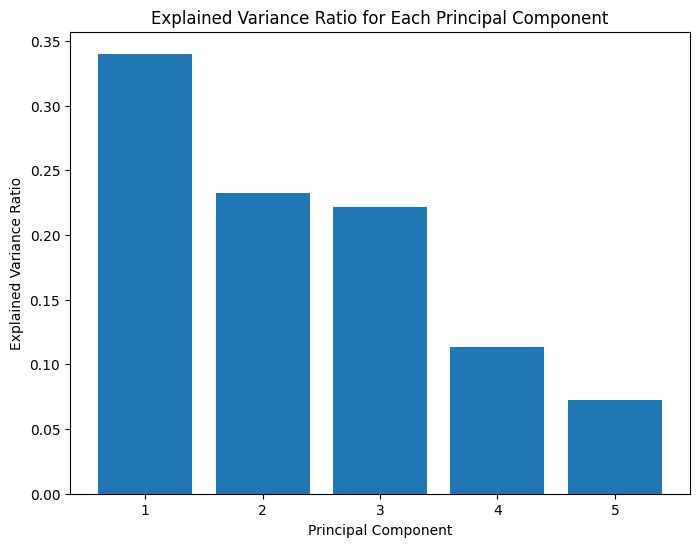

Explained Variance Ratio: [0.14910297 0.08253265 0.06289952 0.0503772  0.03810903]


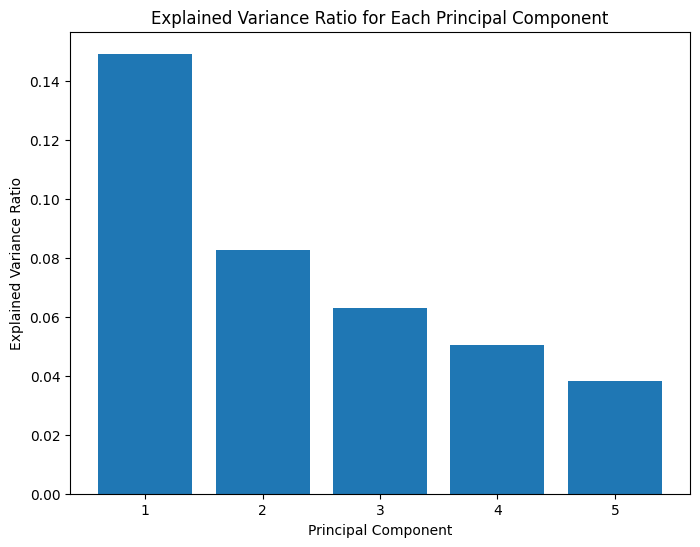

Explained Variance Ratio: [0.15006033 0.08249446 0.06232153 0.04987812 0.03790513]


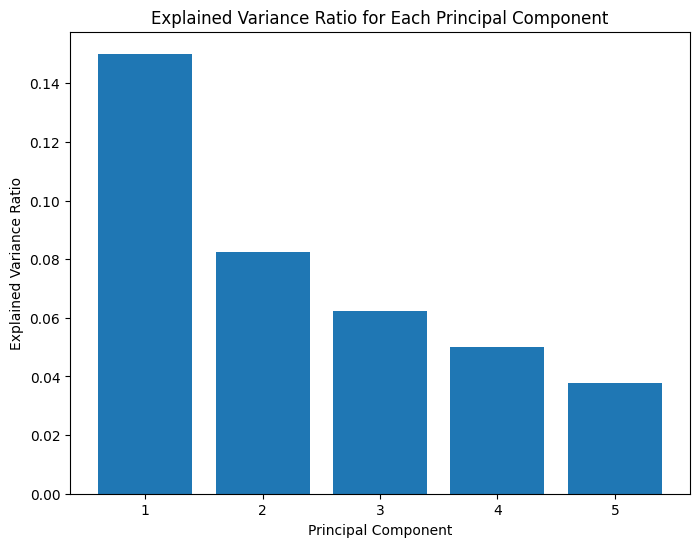

In [127]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Choose the number of components (principal components) you want to retain
n_components = 5 # You can adjust this value based on your visualization needs

pca = PCA(n_components=n_components)
X_train_pca_Mini = pca.fit_transform(nX_train_Tsfresh_Mini)
X_test_pca_Mini = pca.transform(nX_test_Tsfresh_Mini)

explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained Variance Ratio: {explained_variance_ratio}")

# Plot the explained variance for each component
plt.figure(figsize=(8, 6))
plt.bar(range(1, n_components + 1), explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for Each Principal Component')
plt.show()

pca = PCA(n_components=n_components)
X_train_pca_Effi = pca.fit_transform(nX_train_Tsfresh_Effi)
X_test_pca_Effi = pca.transform(nX_test_Tsfresh_Effi)

explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained Variance Ratio: {explained_variance_ratio}")

# Plot the explained variance for each component
plt.figure(figsize=(8, 6))
plt.bar(range(1, n_components + 1), explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for Each Principal Component')
plt.show()

pca = PCA(n_components=n_components)
X_train_pca_Comprehensive = pca.fit_transform(nX_train_Tsfresh_Comprehensive)
X_test_pca_Comprehensive = pca.transform(nX_test_Tsfresh_Comprehensive)

explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained Variance Ratio: {explained_variance_ratio}")

# Plot the explained variance for each component
plt.figure(figsize=(8, 6))
plt.bar(range(1, n_components + 1), explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for Each Principal Component')
plt.show()

In [128]:
# Create a kNN classifier (you can choose an appropriate value for k)
k = 5
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Train the kNN classifier using the PCA-transformed training data
knn_classifier.fit(X_train_pca_Mini, y_train)  # Assuming you have target labels (y_train)

# Make predictions on the PCA-transformed test data
y_pred = knn_classifier.predict(X_test_pca_Mini)

# Evaluate the classifier's performance
accuracy_tsfresh_mini = accuracy_score(y_test, y_pred)
print(f"Accuracy of kNN classifier: {accuracy_tsfresh_mini}")

# Create a kNN classifier (you can choose an appropriate value for k)
k = 5
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Train the kNN classifier using the PCA-transformed training data
knn_classifier.fit(X_train_pca_Effi, y_train)  # Assuming you have target labels (y_train)

# Make predictions on the PCA-transformed test data
y_pred = knn_classifier.predict(X_test_pca_Effi)

# Evaluate the classifier's performance
accuracy_tsfresh_efficient = accuracy_score(y_test, y_pred)
print(f"Accuracy of kNN classifier: {accuracy_tsfresh_efficient}")

# Create a kNN classifier (you can choose an appropriate value for k)
k = 5
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Train the kNN classifier using the PCA-transformed training data
knn_classifier.fit(X_train_pca_Comprehensive, y_train)  # Assuming you have target labels (y_train)

# Make predictions on the PCA-transformed test data
y_pred = knn_classifier.predict(X_test_pca_Comprehensive)

# Evaluate the classifier's performance
accuracy_tsfresh_comprehensive = accuracy_score(y_test, y_pred)
print(f"Accuracy of kNN classifier: {accuracy_tsfresh_comprehensive}")

Accuracy of kNN classifier: 0.5961538461538461
Accuracy of kNN classifier: 0.6538461538461539
Accuracy of kNN classifier: 0.6538461538461539


----
----
# <b> 5 : CESIUM </b>

In [104]:
!pip install cesium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 672.6/672.6 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 554.5/554.5 kB 43.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached setuptools_scm-8.0.4-py3-none-any.whl (42 kB)
  Created wheel for gatspy: filename=gatspy-0.3-py3-none-any.whl size=43804 sha256=3be6f4ea0977af20732df079a3d92820dce3325af58b86bb99e08a0e5e4b56ba
  Stored in directory: /root/.cache/pip/wheels/13/39/c2/d113611d276bf55252ed5a640e98596d7dcc96535afbf254d5
Successfully built gatspy


In [105]:
from cesium import featurize

features_to_use = [
    "amplitude",
    "percent_beyond_1_std",
    "maximum",
    "max_slope",
    "median",
    "median_absolute_deviation",
    "percent_close_to_median",
    "minimum",
    "skew",
    "std",
    "weighted_average",
]

time_points = [np.arange(len(ts)) / fs for ts in X_train]

X_train_Cesium = featurize.featurize_time_series(times=time_points,
                                                  values=X_train,
                                                  features_to_use=features_to_use)
print("End of Training Features")

time_points = [np.arange(len(ts)) / fs for ts in X_test]

X_test_Cesium = featurize.featurize_time_series(times = time_points,
                                                       values=X_test,
                                                       features_to_use=features_to_use)

print("End of Test Features")

End of Training Features
End of Test Features


In [106]:
# Remove low variance features
selector = VarianceThreshold()
X_train_Cesium = selector.fit_transform(X_train_Cesium)
X_test_Cesium = selector.transform(X_test_Cesium)

# Normalising Features
scaler = preprocessing.StandardScaler()
nX_train_Cesium = scaler.fit_transform(X_train_Cesium)
print(nX_train_Cesium.shape)
nX_test_Cesium = scaler.transform(X_test_Cesium)
print(nX_test_Cesium.shape)

(204, 11)
(52, 11)


Explained Variance Ratio: [0.38299018 0.29106683 0.10195746 0.09514739 0.05075116]


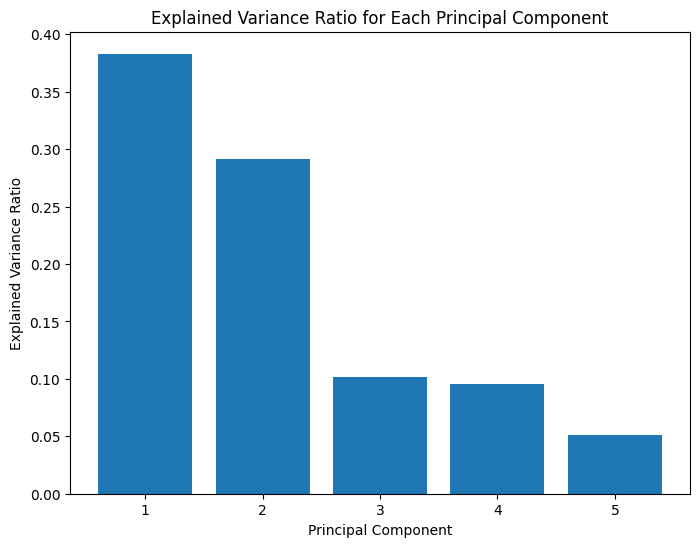

In [135]:
# Choose the number of components (principal components) you want to retain
n_components = 5  # You can adjust this value based on your visualization needs

pca = PCA(n_components=n_components)
X_train_pca_Cesium = pca.fit_transform(nX_train_Cesium)
X_test_pca_Cesium = pca.transform(nX_test_Cesium)

explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained Variance Ratio: {explained_variance_ratio}")

# Plot the explained variance for each component
plt.figure(figsize=(8, 6))
plt.bar(range(1, n_components + 1), explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for Each Principal Component')
plt.show()

In [136]:
# Create a kNN classifier (you can choose an appropriate value for k)
k = 5
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Train the kNN classifier using the PCA-transformed training data
knn_classifier.fit(X_train_pca_Cesium, y_train)  # Assuming you have target labels (y_train)

# Make predictions on the PCA-transformed test data
y_pred = knn_classifier.predict(X_test_pca_Cesium)

# Evaluate the classifier's performance
accuracy_cesium = accuracy_score(y_test, y_pred)
print(f"Accuracy of kNN classifier: {accuracy_cesium}")

Accuracy of kNN classifier: 0.6346153846153846


In [137]:
methods = ['DTW','TSFEL','CESIUM','TSFRESH MINI','TSFRESH EFFICIENT', 'TSFRESH COMPREHENSIVE']
results = [accuracy_dtw,accuracy_tsfel,accuracy_cesium,accuracy_tsfresh_mini,accuracy_tsfresh_efficient,accuracy_tsfresh_comprehensive]

# Create a DataFrame
results_df = pd.DataFrame({
    'Method': methods,
    'Accuracy': results
})

# Display the DataFrame
print(results_df)

                  Method  Accuracy
0                    DTW  0.826923
1                  TSFEL  0.711538
2                 CESIUM  0.634615
3           TSFRESH MINI  0.596154
4      TSFRESH EFFICIENT  0.653846
5  TSFRESH COMPREHENSIVE  0.653846


----
----
# <b> 6 : Random Forest</b>

In [110]:
classifier = RandomForestClassifier()
# Train the classifier
classifier.fit(nX_train_generic, y_train)

# Predict test data
y_test_predict = classifier.predict(nX_test_generic)

# Get the classification report
accuracy = accuracy_score(y_test, y_test_predict) * 100
print("Accuracy: " + str(accuracy) + '%')

Accuracy: 82.6923076923077%


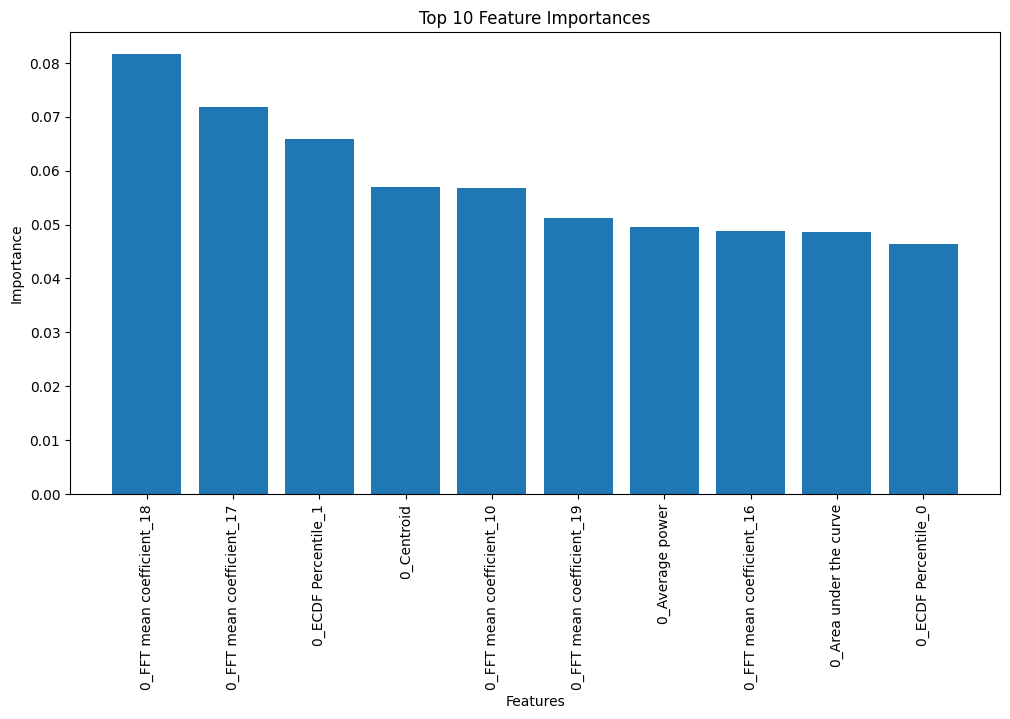

In [111]:
# Assuming you have already fitted the Random Forest classifier and obtained feature importances
feature_importances = classifier.feature_importances_

# Get the feature names
feature_names = X_train_generic.columns

# Sort feature importances and feature names together
sorted_indices = feature_importances.argsort()[::-1]  # Sort in descending order
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Select only the top 10 features
top_10_indices = sorted_indices[:10]
top_10_feature_importances = sorted_feature_importances[:10]
top_10_feature_names = sorted_feature_names[:10]

# Create a bar plot to visualize the top 10 feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(len(top_10_feature_importances)), top_10_feature_importances, tick_label=top_10_feature_names)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importances')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
# Calculate the cumulative sum of feature importances
cumulative_variances = np.cumsum(sorted_feature_importances)
